In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import (polygon, circle)
from scipy import ndimage as ndi
from skimage import color
from skimage import io
import time

In [2]:
def dsquare(r0,c0):
    width=30/2
    height=30/2
    rr, cc = [r0-15, r0 -15 , r0 + 15, r0+15], [c0-15, c0+15, c0 +15, c0 -15]
    return rr,cc
def dtriangle(r,c):
    a=30
    rr,cc=[r+a/3.3,r+a/3.3,r-a/2],[c-a/2,c+a/2,c]
    return rr,cc
def dbox(r0,c0):
    width=60
    height=60
    rr, cc = [r0-30, r0 -30 , r0 + 30, r0+30], [c0-30, c0+30, c0 +30, c0 -30]
    return rr,cc

# 1) Complex cell using Gabor filter bank

In [3]:
def complexcell(box,plot=False):
    if plot:
        fig,ax=plt.subplots(2,2,figsize=[10,5])
        ori=[0,60,90,120]
    threshold=[0.02,0.005,0.004,0.004]
    angles=[0,np.pi/3,np.pi/2,2*np.pi/3]
    response=np.zeros(4)
    for i in range(len(angles)):
        gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=angles[i], lambd=4, gamma=2, psi=0)
        box=color.rgb2gray(box)
        filtered = ndi.convolve(box, gabor_kernel, mode='wrap')
        filtered[filtered<0.85]=0
        if plot:
            ax[int(i/2),int(i%2)].imshow(gabor_kernel,cmap='gray')
            ax[int(i/2),int(i%2)].set_title("GaborKernel at "+str(ori[i])+" degree")
            ax[int(i/2),int(i%2)].axis("off")
        if(filtered.mean()<threshold[i]):
            response[i]=0
        else:
            response[i]=1
    if(response[0]==1 and response[2]==1):   # response for 90 and 0 degree#
        return "square"
    if(response[1]==1 and response[2]==1 and response[3]==1):#response for 0,60,120  then triangle#
        return "triangle"

## Sample Shapes 

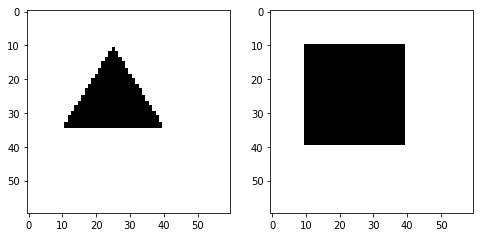

In [4]:
tri = np.ones((60, 60, 3), dtype=np.double)
rr,cc=dtriangle(25,25)
rr,cc=polygon(rr,cc, tri.shape);tri[rr, cc, :] = 0
rec = np.ones((60, 60, 3), dtype=np.double)
rr,cc=dsquare(25,25)
rr,cc=polygon(rr,cc, rec.shape);rec[rr, cc, :] = 0
fig,ax=plt.subplots(1,2,figsize=[8,5])
ax[0].imshow(tri)
ax[1].imshow(rec)
plt.show()

## Gabor Kernel at different thetha

square
triangle


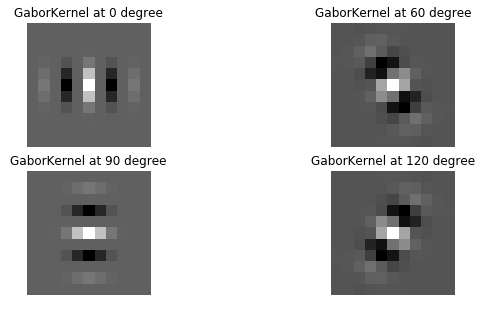

In [5]:
print(complexcell(rec,plot=False)) #square image given as input
print(complexcell(tri,plot=True)) #triangle image given as input
plt.savefig('GaborResponse.png', bbox_inches='tight')

### Sample response for rectangle.

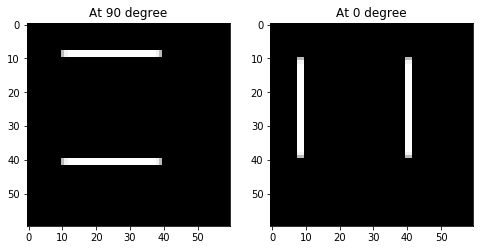

In [6]:
gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=np.pi/2, lambd=4, gamma=2, psi=0)
rec=color.rgb2gray(rec)
filtered = ndi.convolve(rec, gabor_kernel, mode='wrap')
filtered[filtered<0.85]=0
fig,ax=plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(filtered,cmap='gray')
ax[0].set_title("At 90 degree")
gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=0, lambd=4, gamma=2, psi=0)
rec=color.rgb2gray(rec)
filtered = ndi.convolve(rec, gabor_kernel, mode='wrap')
filtered[filtered<0.85]=0
ax[1].imshow(filtered,cmap='gray')
ax[1].set_title("At 0 degree")
plt.savefig('RectangleResponse.png', bbox_inches='tight')
plt.show()

### Sample response for Triangle

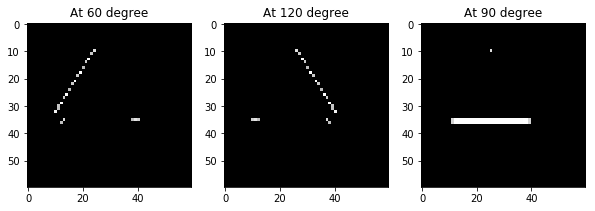

In [7]:
gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=np.pi/3, lambd=4, gamma=2, psi=0)
tri=color.rgb2gray(tri)
filtered = ndi.convolve(tri, gabor_kernel, mode='wrap')
filtered[filtered<1.05]=0
fig,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(filtered,cmap='gray')
ax[0].set_title("At 60 degree")
gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=2*np.pi/3, lambd=4, gamma=2, psi=0)
filtered = ndi.convolve(tri, gabor_kernel, mode='wrap')
filtered[filtered<1.05]=0
ax[1].imshow(filtered,cmap='gray')
ax[1].set_title("At 120 degree")
gabor_kernel = cv2.getGaborKernel(ksize=(11,11), sigma=2, theta=np.pi/2, lambd=4, gamma=2, psi=0)
filtered = ndi.convolve(tri, gabor_kernel, mode='wrap')
filtered[filtered<1.05]=0
ax[2].imshow(filtered,cmap='gray')
ax[2].set_title("At 90 degree")
plt.savefig('TriangleResponse.png', bbox_inches='tight')
plt.show()

# 2) Image generation for paradigm

In [8]:
def findnonoverlapping(tobjects):
    img = np.ones((600, 600, 3), dtype=np.double)
    j=0
    mainpos=[]
    while j<tobjects:
        posx=np.random.randint(70,520,1)
        posy=np.random.randint(70,520,1)
        rr,cc=dsquare(posx,posy)
        rrb,ccb=dbox(posx,posy)
        rr,cc=polygon(rr,cc, img.shape)
        rrb,ccb=polygon(rrb,ccb, img.shape)
        flag=1
        for i in range(len(rr)):
            if(img[rr[i],cc[i],2]==0.5):
                flag=0
                break
        if(flag):
            img[rrb, ccb, 2] = 0.5
            j+=1
            mainpos.append((posx,posy))
    return mainpos 

In [9]:
def drawinimage(img,shp,color,pos):
    if(shp=="triangle"):
        row,col=dtriangle(pos[0],pos[1])
    else:
        row,col=dsquare(pos[0],pos[1])
        
    if(color=="red"):
            pc=(1,0,0)
    else:
        pc=(0,0,1)
    row,col=polygon(row,col,img.shape)
    img[row,col,:]=pc
    return img

In [10]:
def GeneratePardigm(tobjects=10,paradigm="feature"):
    mainpos=findnonoverlapping(tobjects)
    img = np.ones((600, 600, 3), dtype=np.double)
    if(paradigm=="conjuction"):
        conj=[("red","square"),("red","triangle"),("blue","square"),("blue","triangle")]
        oddconj=conj[np.random.randint(4)]
        conj.remove(oddconj)
        for i in range(len(mainpos)-1):
            dis=conj[np.random.randint(3)]
            color=dis[0]
            shape=dis[1]
            img=drawinimage(img,shape,color,mainpos[i])
        img=drawinimage(img,oddconj[1],oddconj[0],mainpos[i+1])
        
    if(paradigm=="feature"):
        ftr=["color","shape"][np.random.randint(2)]
        clr=["red","blue"][np.random.randint(2)]
        shp=["square","triangle"][np.random.randint(2)]
        if(ftr=="color"):
            oddshape=shp
            c=["red","blue"]
            c.remove(clr)
            oddcolor=c[0]
        else:
            s=["square","triangle"]
            s.remove(shp)
            oddcolor=clr
            oddshape=s[0]
        for i in range(len(mainpos)-1):
            img=drawinimage(img,shp,clr,mainpos[i])
        img=drawinimage(img,oddshape,oddcolor,mainpos[i+1])
        
    return img,mainpos
    

## Feature and Conjuction Image Frames:
#### In case of Feature any one of color or shape can be feature(randomly)
Please make sure that no of distractor not gretater than 60 that much will not fit in image size used.

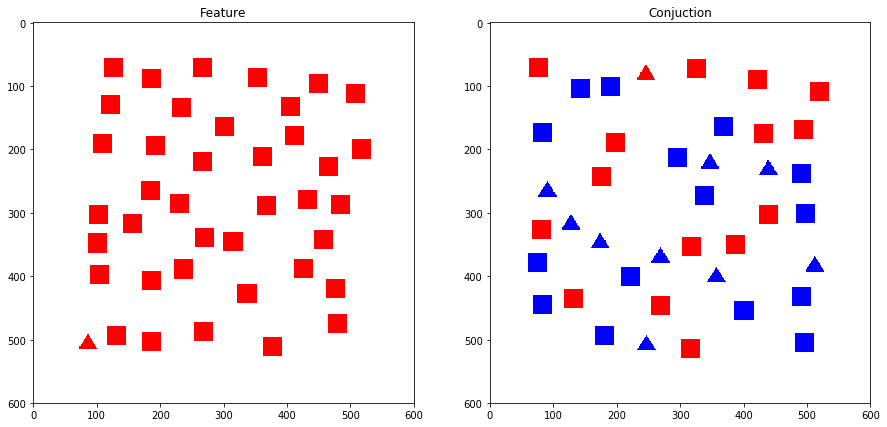

In [11]:
img,mainpos=GeneratePardigm(40,"feature")
img2,mainpos2=GeneratePardigm(40,"conjuction")
plt.figure(figsize=(15,10))
plt.subplot(1,2,1);plt.imshow(img);plt.title("Feature")
plt.subplot(1,2,2);plt.imshow(img2);plt.title("Conjuction")
plt.savefig('ImageFrame.png', bbox_inches='tight')
plt.show()


# 3) Simulation of Feature Integration Theory

#### Result of complex cell on above conjuction image

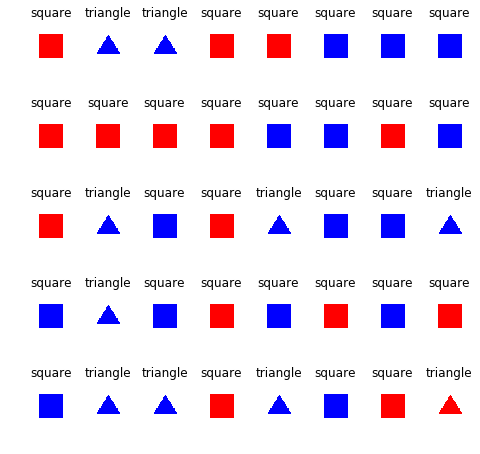

In [12]:
fig = plt.figure(figsize=(8,8))
for i in range(len(mainpos2)):
    pos=mainpos2[i]
    r,c=dbox(pos[0],pos[1])
    r1,r2=int(r[0]),int(r[2])
    c1,c2=int(c[0]),int(c[2])
    box=img2[r1:r2,c1:c2]
    plt.subplot(5,8,i+1)
    plt.title(complexcell(box,plot=False))
    plt.axis("off")
    plt.imshow(box)
plt.savefig('PreAttentive.png', bbox_inches='tight')
plt.show()

In [13]:
def GetColor(pos,img):
    clr=img[pos[0],pos[1]]
    if(clr[0]==1):
        return "red"
    if(clr[2]==1):
        return "blue"
def GetShape(pos,img):
    r,c=dbox(pos[0],pos[1])
    r1,r2=int(r[0]),int(r[2])
    c1,c2=int(c[0]),int(c[2])
    box=img[r1:r2,c1:c2]
    return complexcell(box)

In [14]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [15]:
def findodd(img,mainpos,colorinfo,shapeinfo):    
    mobject=[]
    c=1
    setcolorinfo=set(colorinfo.values())
    setshapeinfo=set(shapeinfo.values())
    for d in mainpos:
        time.sleep(0.00001) 
        # simulated delay for neural response#######################
        pos=(d[0][0],d[1][0])
        ########################################feature search#######################################
        # no need to go through location map########################################################
        if(len(setcolorinfo)==1 or len(setshapeinfo)==1):
            if(len(setcolorinfo)!=1):
                dealinfo=colorinfo
            else:
                dealinfo=shapeinfo
            
            lfo=list(dealinfo.values())
            unique=[lfo[0]]
            seen=[lfo[0]]
            loc=mainpos[0]
            for i in range(1,len(lfo)):
                if(lfo[i] in unique or lfo[i] in seen):
                    seen.append(lfo[i])
                    if(lfo[i] in unique):
                        unique.remove(lfo[i])
                else:
                    unique.append(lfo[i])
                    loc=mainpos[i]
            break
        ###################################################################################################
        else:
            ###########Conjuction search need to go through all the 
            #location in Master map to detect unique element
            objectinfo=colorinfo[pos]+" "+shapeinfo[pos]
            if(c==1):
                unique=[objectinfo];seen=[];c=1-c;loc=pos
            if(objectinfo in unique or objectinfo in seen):
                seen.append(objectinfo)
                if(objectinfo in unique):
                    unique.remove(objectinfo)
            else:
                unique.append(objectinfo)
                loc=pos
    return loc

In [16]:
def PreAttentiveFeature(img,mainpos):
    colorinfo={}
    shapeinfo={}
    for i in mainpos:
        pos=(i[0][0],i[1][0])
        colorinfo[pos]=GetColor(pos,img)
        shapeinfo[pos]=GetShape(pos,img)
    return (colorinfo,shapeinfo)

### Sample Result for Feature Search:

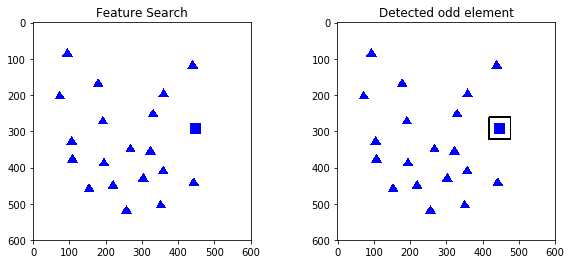

In [17]:
img,mainpos=GeneratePardigm(20,"feature")
fig,ax=plt.subplots(1,2,figsize=[10,4])
colorinfo,shapeinfo=PreAttentiveFeature(img,mainpos)
loc=findodd(img,mainpos,colorinfo,shapeinfo)
pos=loc
ax[0].imshow(img)
ax[0].set_title("Feature Search")
r,c=dbox(pos[0],pos[1])
r1,r2=int(r[0]),int(r[2])
c1,c2=int(c[0]),int(c[2])
img = cv2.rectangle(img,(c1,r1),(c2,r2),(0,0,0),3)
ax[1].imshow(img)
ax[1].set_title("Detected odd element")
plt.savefig('Featureodd.png', bbox_inches='tight')
plt.show()

### Sample Result for Conjuction Search:

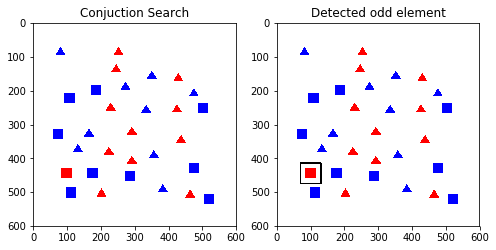

In [18]:
img,mainpos=GeneratePardigm(30,"conjuction")
fig,ax=plt.subplots(1,2,figsize=[8,4])
colorinfo,shapeinfo=PreAttentiveFeature(img,mainpos)
loc=findodd(img,mainpos,colorinfo,shapeinfo)
pos=loc
ax[0].imshow(img)
ax[0].set_title("Conjuction Search")
r,c=dbox(pos[0],pos[1])
r1,r2=int(r[0]),int(r[2])
c1,c2=int(c[0]),int(c[2])
img = cv2.rectangle(img,(c1,r1),(c2,r2),(0,0,0),3)
ax[1].imshow(img)
ax[1].set_title("Detected odd element")
plt.savefig('Conjuctionodd.png', bbox_inches='tight')
plt.show()

## Graph of response time vs No. of distractor

In [19]:
################################################Feature################################################
responsetimefeature=[]
for i in range(4,50):
    img,mainpos=GeneratePardigm(i,"feature")
    colorinfo,shapeinfo=PreAttentiveFeature(img,mainpos)
    
    t=time.time()#######################################start of response time#################
    loc=findodd(img,mainpos,colorinfo,shapeinfo)
    responsetimefeature.append(time.time()-t)

    
################################################Conjuction###############################################
responsetimeconjuction=[]
for i in range(4,50):
    img,mainpos=GeneratePardigm(i,"conjuction")
    colorinfo,shapeinfo=PreAttentiveFeature(img,mainpos)
    
    
    t=time.time()#######################################start of response time#################
    loc=findodd(img,mainpos,colorinfo,shapeinfo)
    responsetimeconjuction.append(time.time()-t)

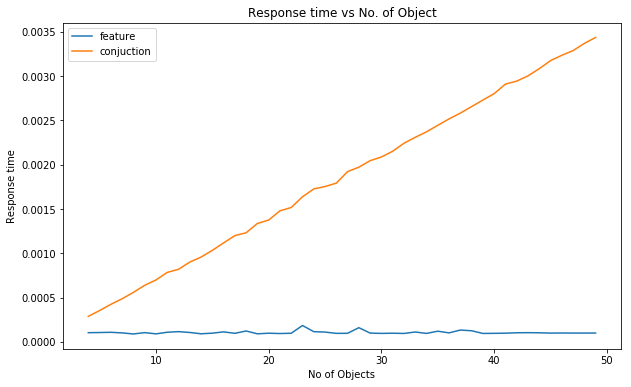

In [20]:
plt.figure(figsize=(10,6))
responsetimes=np.array(responsetimefeature)
responsetimes2=np.array(responsetimeconjuction)
plt.plot([i for i in range(4,50)],responsetimes)
plt.plot([i for i in range(4,50)],responsetimes2)
plt.legend(["feature","conjuction"],loc=2)
plt.xlabel("No of Objects")
plt.ylabel("Response time")
plt.title("Response time vs No. of Object")
plt.savefig('ResponseGraph.png', bbox_inches='tight')
plt.show()

#### ________________________________________________END________________________________________________